<a href="https://colab.research.google.com/github/arvind2047/gl_capstone/blob/interim_Week2_workarea/GL_AIML_Capstone_Sep2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAPSTONE PROJECT: AUTOMATIC TICKET ASSIGNMENT**


#### Problem Statement:

Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

#### The objective of the project is,
 Learn how to use different classification models.

 Use transfer learning to use pre-built models. 

 Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.

 Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.


## IMPORT LIBRARIES

In [85]:
!pip install googletrans
!pip install contractions

In [344]:
# Basic python computation and visualization
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

# Deep Learning Libraries and models
import keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import io
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

# Model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2
from sklearn.cluster import AgglomerativeClustering 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
import pickle
plt.style.use('ggplot')
%matplotlib inline

# NLP text handling libraries
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk import pos_tag
from string import punctuation
from wordcloud import WordCloud
import googletrans
from googletrans import Translator
from collections import Counter
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import contractions

# General purpose
import os
from zipfile import ZipFile
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Setup project path:
os.chdir('/content/drive/My Drive/GL AIML Capstone')
os.getcwd()

'/content/drive/My Drive/GL AIML Capstone'

---

## LOAD DATA

In [87]:
# read and load data
incidents = pd.read_excel("input_data.xlsx")
incidents.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [88]:
## basic info
print('Number of data items',incidents.shape[0],'\n')
incidents.info()

Number of data items 8500 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [89]:
incidents.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


*   There are empty 'Description' and 'Short Description' rows
*   There are 74 unique assignment groups - GRP_0 the most frequent item with 3976 entries


---

## DATA CLEANSING AND PRE-PROCESSING

In [90]:
## find NA
incidents[incidents.isna().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,"\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail.com\r\n\r\nhi,\r\n\r\n\r\n\r\nlink is not working. kindly resolve yhe issue on urgent basis.\r\n\r\n\r\n\r\nbest",ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamviewer.\r\n-help the user login to the portal.\r\n-issue resolved.,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to the user system using teamviewer.\r\n-help the user login to the company vpn using the vpn company vpn link.\r\n-issue resolved.,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to the user system using teamviewer.\r\n-help the user login to the company vpn using the vpn company vpn link.\r\n-issue resolved.,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to the user system using teamviewer.\r\n-help the user login to the company vpn using the vpn company vpn link.\r\n-issue resolved.,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to the user system using teamviewer.\r\n-help the user login to the company vpn using the vpn company vpn link.\r\n-issue resolved.,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:microsoft internet explorer\nemail:wvqgbdhm.fwchqjor@gmail.com\ncustomer number:\ntelephone:-not available\nsummary:can't get into vpn - need to be on at 4:30 est and it wont' happen please help aerp!,wvqgbdhm fwchqjor,GRP_0
4341,NaN,"\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail.com\r\n\r\ngood morning,\r\n\r\nwhen trying to log on to erp i get this error below.\r\nplease help urgently as i can not process customer order.\r\n\r\n[cid:image001.png@01d20f2e.751db880]\r\n\r\n\r\n",eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [91]:
# drop nulls
incidents.dropna(inplace=True)
print('Removing rows with null values')
print(incidents.shape)

Removing rows with null values
(8491, 4)


In [92]:
# drop duplicates
print('Removing',incidents[incidents.duplicated()].shape[0],'duplicate rows')
incidents = incidents.drop_duplicates()
print(incidents.shape)

Removing 83 duplicate rows
(8408, 4)


In [93]:
# Converting to lowercase
incidents = incidents.apply(lambda x: x.astype(str).str.lower())

In [94]:
# Removing special characters
incidents['Short description']  = incidents['Short description'].map(lambda x: re.sub(r'\W', ' ', x))
incidents['Description'] = incidents['Description'].map(lambda x: re.sub(r'\W', ' ', x))

In [95]:
incidents.head()

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,spxjnwir pjlcoqds,grp_0
1,outlook,received from hmjdrvpb komuaywn gmail com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,hmjdrvpb komuaywn,grp_0
2,cant log in to vpn,received from eylqgodm ybqkwiam gmail com hi i cannot log on to vpn best,eylqgodm ybqkwiam,grp_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0
4,skype error,skype error,owlgqjme qhcozdfx,grp_0


---

## EXPLORATORY DATA ANALYSIS

### Distribution by group

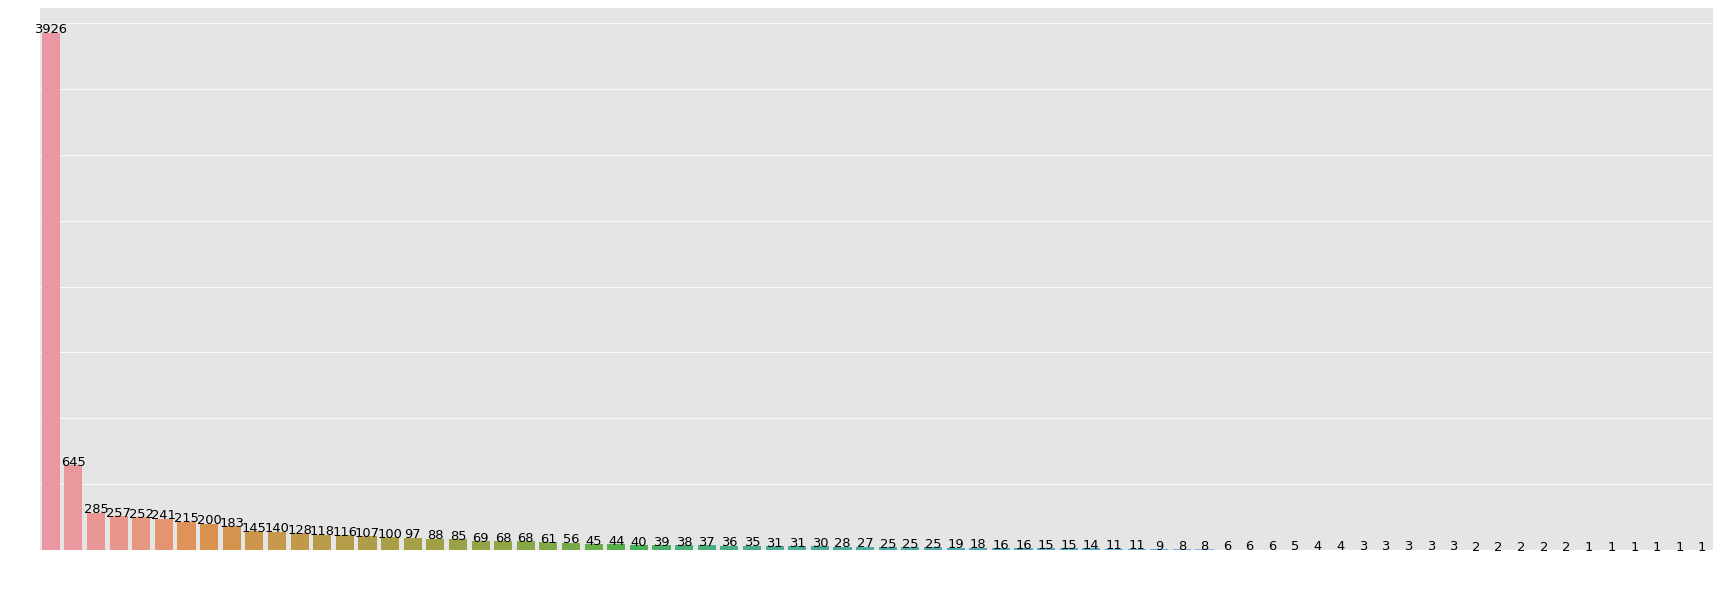

In [96]:
assgn = incidents['Assignment group'].value_counts()
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
cntplot = sns.barplot(x=assgn.index,y=assgn.values)
cntplot.set_xticklabels(cntplot.get_xticklabels(),rotation=90)
for i in range(len(assgn)):
  cntplot.text(i, assgn.values[i], assgn.values[i], color='black', ha='center', fontsize=13)
plt.show()

The data is extremely unbalanced towards GRP_0 and GRP_8 with their data occupying 55% of the available data. We have to resolve the imbalance before modelling.

### Caller - assignment group analysis to identify any patterns

In [97]:
incidents['Caller'].describe()

count                  8408
unique                 2948
top       bpctwhsn kzqsbmtp
freq                    788
Name: Caller, dtype: object

*   There are 2948 unique callers who have submitted tickets.
*   'bpctwhsn kzqsbmtp' is the most frequent caller with 788 records  

Let us try to explore any relation between the caller and assignment groups.

In [98]:
incidents_freqgrp = incidents[incidents['Assignment group'].isin(list(incidents['Assignment group'].value_counts()[incidents['Assignment group'].value_counts()>10].index))]
freq_grp = (np.max(pd.crosstab(incidents_freqgrp['Caller'],incidents_freqgrp['Assignment group'])) /
            np.sum(pd.crosstab(incidents_freqgrp['Caller'],incidents_freqgrp['Assignment group']))).sort_values(ascending=False)
grp_df = incidents_freqgrp[incidents_freqgrp['Assignment group'].isin(list(freq_grp[freq_grp>0.4].index))].groupby(by='Assignment group').agg(lambda x:x.value_counts().index[0])
grp_df.loc[freq_grp[freq_grp>0.4].index,'Percentage tickets by most frequent caller'] = freq_grp[freq_grp>0.4].round(3).values
grp_df.loc[freq_grp[freq_grp>0.4].index,'Total records for group'] = incidents[incidents['Assignment group'].isin(list(freq_grp[freq_grp>0.4].index))]['Assignment group'].value_counts()
grp_df.drop(columns=['Short description','Description'])

,Caller,Percentage tickets by most frequent caller,Total records for group
Assignment group,,,
grp_10,bpctwhsn kzqsbmtp,0.429,140
grp_41,entuakhp xrnhtdmk,0.550,40
grp_5,bpctwhsn kzqsbmtp,0.742,128
grp_6,bpctwhsn kzqsbmtp,0.481,183
grp_60,bpctwhsn kzqsbmtp,0.750,16
grp_8,bpctwhsn kzqsbmtp,0.536,645
grp_9,bpctwhsn kzqsbmtp,0.607,252


As we can see in above table, 'bpctwhsn kzqsbmtp' is the most frequent caller for certain groups - for example, of the 128 records for GRP_5, tickets from this caller accounts for around 75%   






In [99]:
incidents_freqcall = incidents[incidents['Caller'].isin(list(incidents['Caller'].value_counts()[incidents['Caller'].value_counts()>20].index))]
freq_call = (np.max(pd.crosstab(incidents_freqcall['Assignment group'],incidents_freqcall['Caller'])) /
            np.sum(pd.crosstab(incidents_freqcall['Assignment group'],incidents_freqcall['Caller']))).sort_values(ascending=False)
call_df = incidents_freqcall[incidents_freqcall['Caller'].isin(list(freq_call[freq_call>0.7].index))].groupby(by='Caller').agg(lambda x:x.value_counts().index[0])
call_df.loc[freq_call[freq_call>0.7].index,'Percentage tickets by most frequent group'] = freq_call[freq_call>0.7].round(3).values
call_df.loc[freq_call[freq_call>0.7].index,'Total records for caller'] = incidents[incidents['Caller'].isin(list(freq_call[freq_call>0.7].index))]['Caller'].value_counts()
call_df.drop(columns=['Short description','Description'])

,Assignment group,Percentage tickets by most frequent group,Total records for caller
Caller,,,
efbwiadp dicafxhv,grp_0,1.000,45
entuakhp xrnhtdmk,grp_41,0.880,25
fumkcsji sarmtlhy,grp_0,0.984,128
jionmpsf wnkpzcmv,grp_24,0.958,24
olckhmvx pcqobjnd,grp_0,1.000,47
rbozivdq gmlhrtvp,grp_0,0.986,72


*   Based on the caller based analysis above, we can see that all the records for callers 'efbwiadp dicafxhv' and 'olckhmvx pcqobjnd' are assigned to GRP_0. Again, we can't consider this significant because GRP_0 records account for half of all input data.
*   Consider the volume of total records, we conclude there is no significant correlation between caller and assignment group. Once we identify that certain groups are similar, we can cluster them and look back at similar analysis again.



### Short description length analysis and its relation with assignment group

In [100]:
incidents['sdesc_len'] = incidents['Short description'].str.len()

Text(0.5, 1.0, 'Distribution of length of short descriptions')

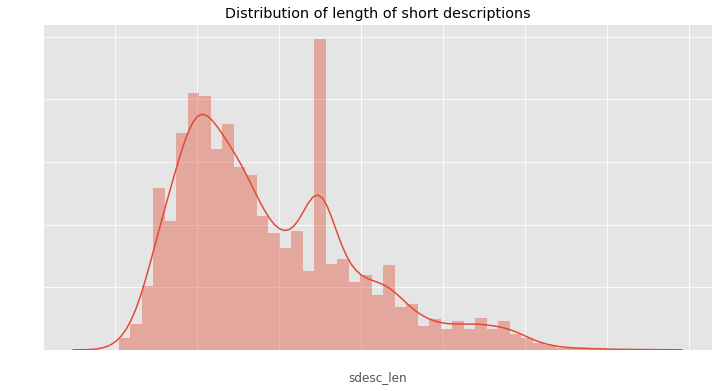

In [101]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['sdesc_len']).set_title('Distribution of length of short descriptions')

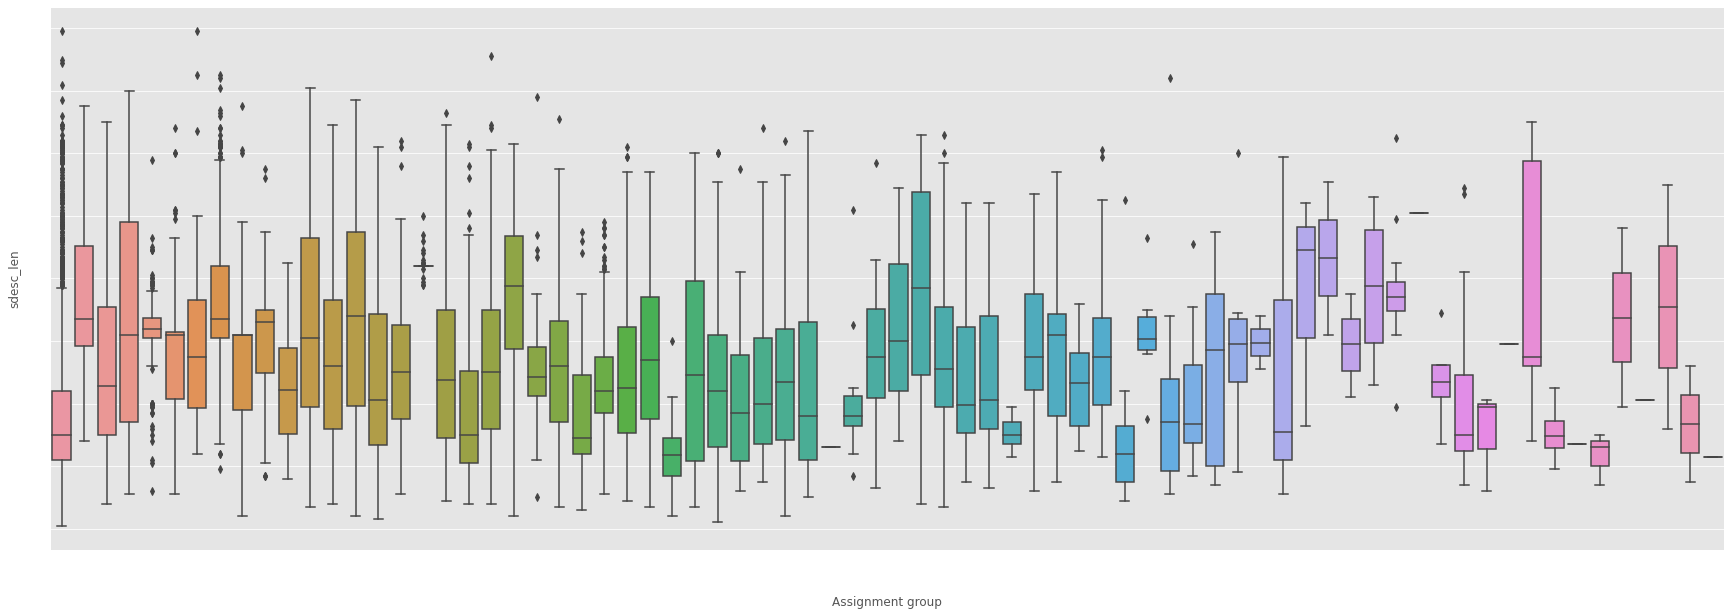

In [102]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='sdesc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see most of the short description are around 30 to 80 characters long with mean length around 50. However, we can see data for certain groups are either on the upper range (GRP_20, GRP_1, GRP_56), while some have a characteristic to have lower lengths (GRP_0, GRP_48, GRP_19).

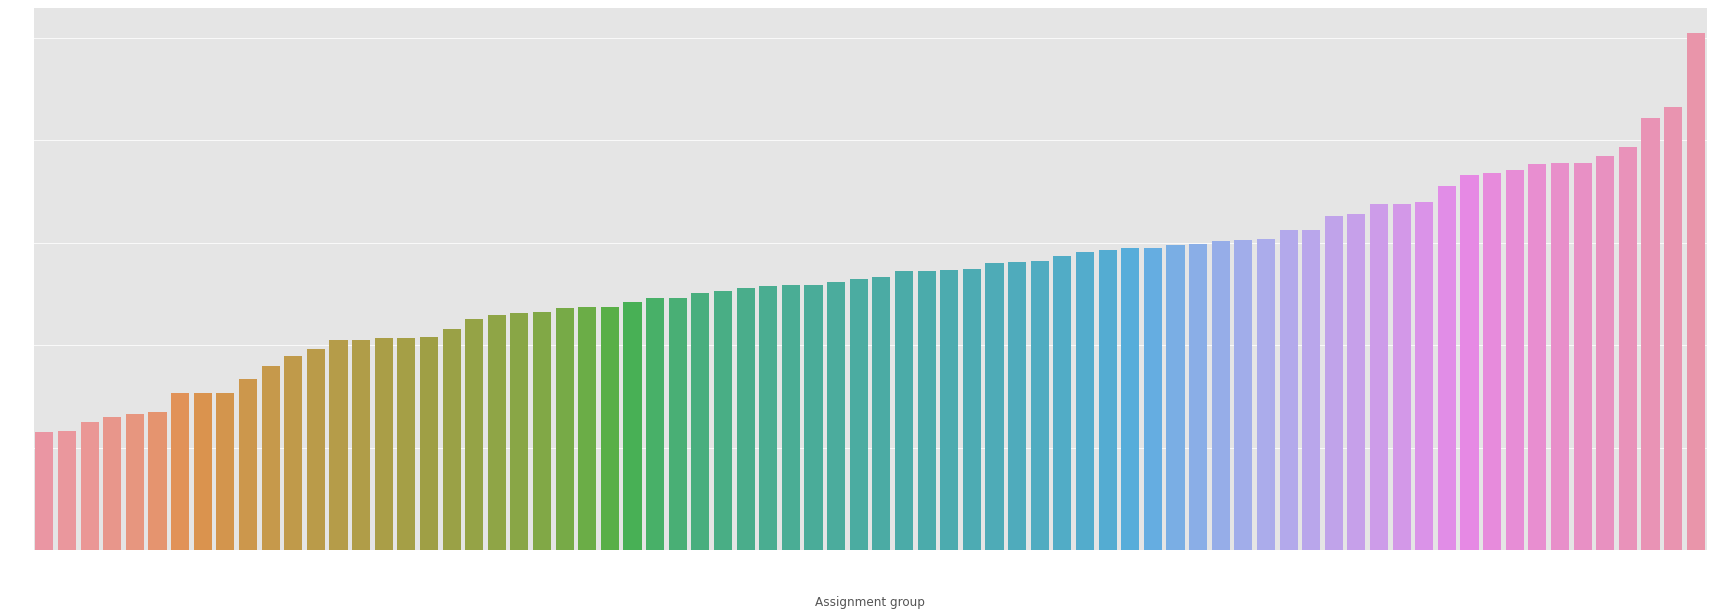

In [103]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meansdesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().values)
plot_meansdesc_len.set_xticklabels(plot_meansdesc_len.get_xticklabels(),rotation=90)
plt.show()

Again, we are seeing a pattern with GRP_56 and GRP_43 records typically having longer lengths in contrast to most other groups having lengths below 200 characters. 

### Description length analysis and its relation with assignment group

In [104]:
incidents['desc_len'] = incidents['Description'].str.len()

Text(0.5, 1.0, 'Distribution of length of descriptions')

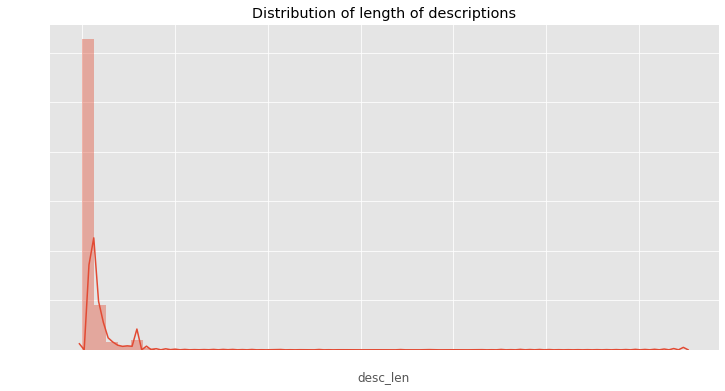

In [105]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['desc_len']).set_title('Distribution of length of descriptions')

The distribution of description lengths is extremely skewed, let us try to omit the tail and focus the major portion from the right skewed graph.

In [106]:
incidents['desc_len'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count     8408.00000
mean       205.55471
std        522.22436
min          1.00000
25%         42.00000
50%        106.00000
75%        203.00000
90%        397.00000
95%        680.65000
max      13001.00000
Name: desc_len, dtype: float64

In [107]:
len(incidents[incidents['desc_len'] > 680])

421

95% of the descriptions have length lesser than 680 characters, lets plot the distribution for them.

Text(0.5, 1.0, 'Distribution of length of descriptions')

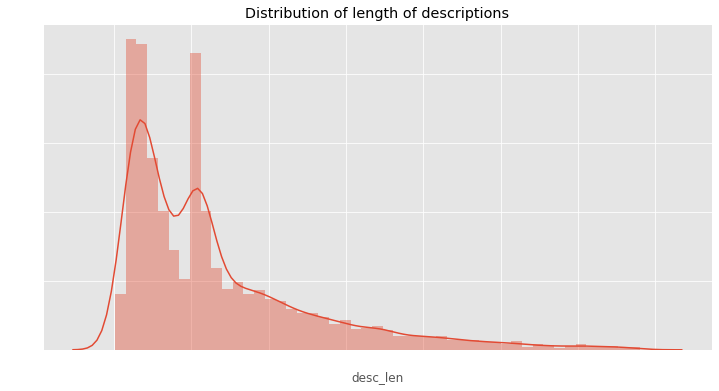

In [108]:
incidents_95 = incidents[incidents['desc_len'] < incidents['desc_len'].quantile(0.95)]
plt.figure(figsize=(12,6))
sns.distplot(incidents_95['desc_len']).set_title('Distribution of length of descriptions')

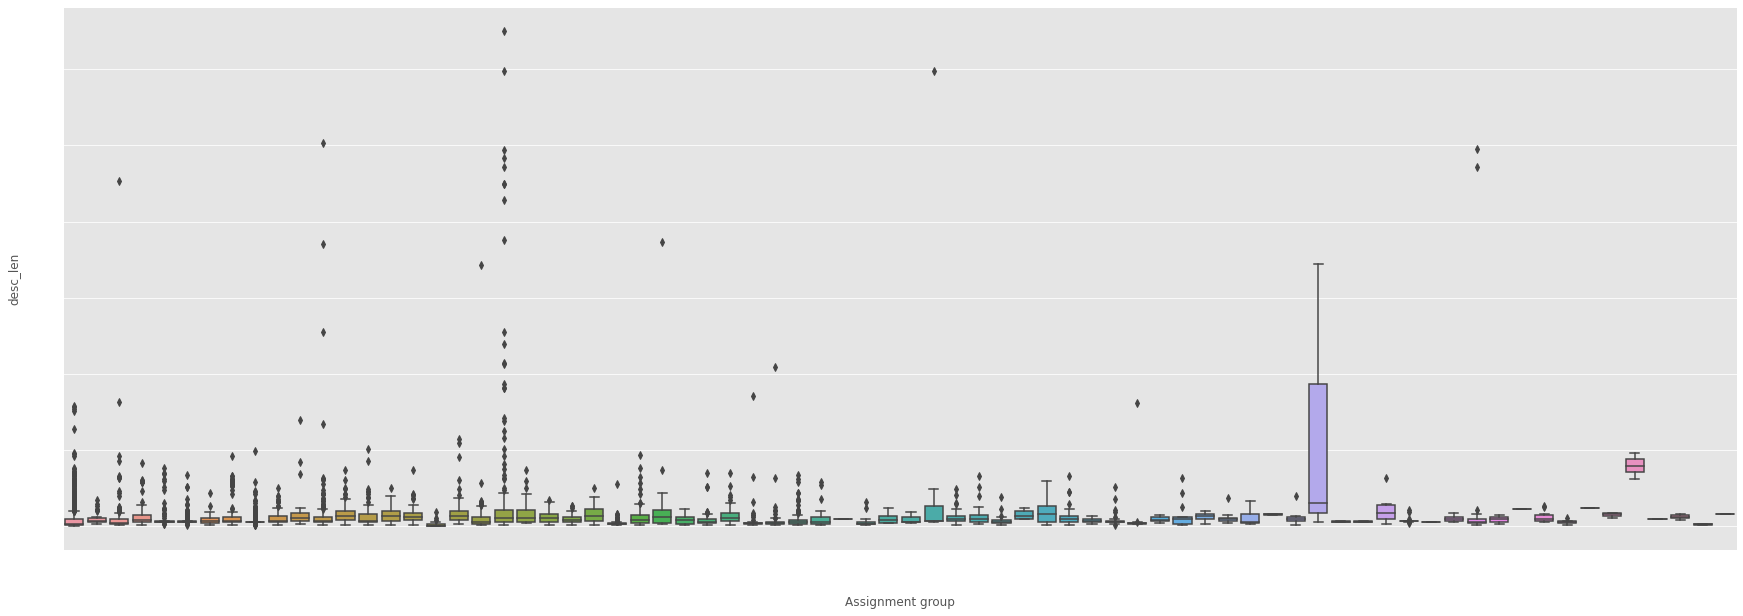

In [109]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see clearly GRP_56 is dominating with long descriptions. We will again try to restrict data of only particular limit.

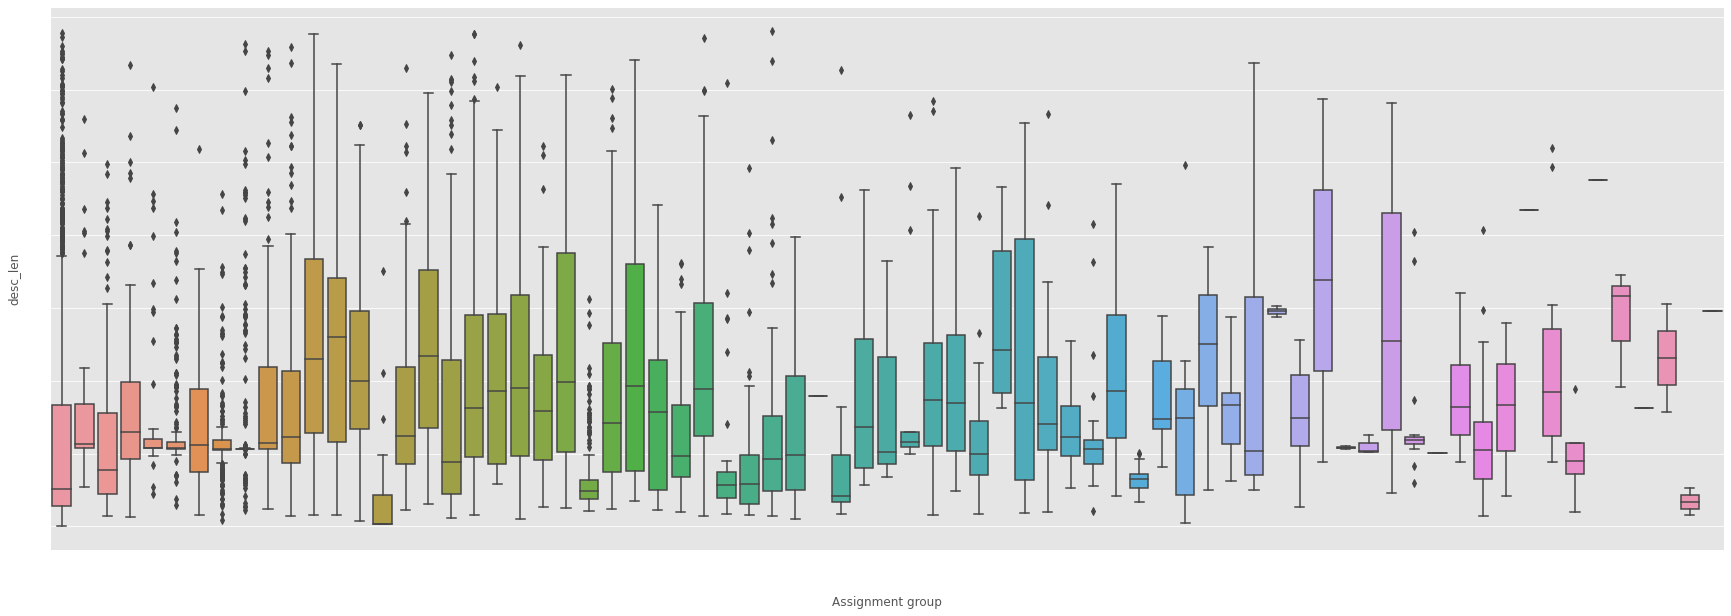

In [110]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents_95, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

Let us plot the mean lengths of description columns.

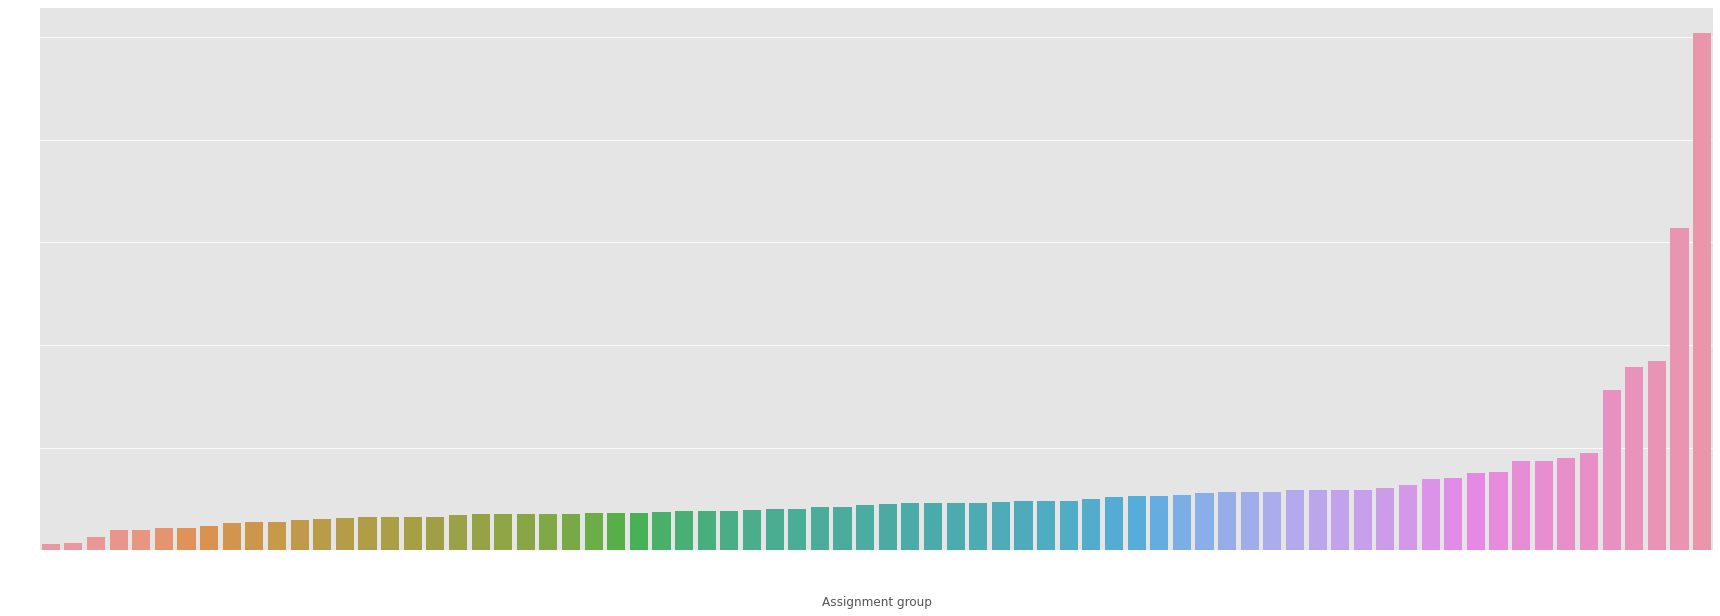

In [111]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meandesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().values)
plot_meandesc_len.set_xticklabels(plot_meandesc_len.get_xticklabels(),rotation=90)
plt.show()

There is a clear distinction between the data of five groups which have very large description data. We will consider this significant and try to identify if the length has any relation with the content once we generate embeddings.

In [112]:
incidents['isSubstr'] = incidents.apply(lambda x: x['Short description'] not in x['Description'], axis=1)
incidents.loc[incidents['isSubstr']==True, 'Description'] = incidents['Short description'] + ' ' + incidents['Description']

In [113]:
incidents.drop(columns=['Short description','sdesc_len','desc_len','isSubstr'],inplace=True)
incidents.head()

,Description,Caller,Assignment group
0,login issue verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,spxjnwir pjlcoqds,grp_0
1,received from hmjdrvpb komuaywn gmail com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,hmjdrvpb komuaywn,grp_0
2,cant log in to vpn received from eylqgodm ybqkwiam gmail com hi i cannot log on to vpn best,eylqgodm ybqkwiam,grp_0
3,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0
4,skype error,owlgqjme qhcozdfx,grp_0


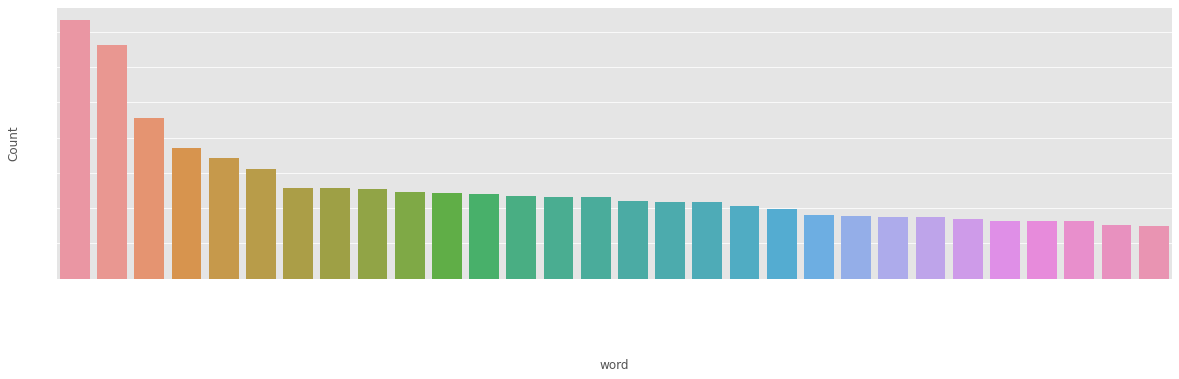

In [114]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  plt.rcParams['xtick.color'] = 'white'
  plt.rcParams['ytick.color'] = 'white'
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  plt.show()

freq_words(list(incidents['Description']))

In [115]:
#expanding contractions ('nt, 's)
incidents['Description'] = incidents['Description'].apply(lambda v: contractions.fix(v))

#remove spaces trailing
incidents['Description'] = incidents['Description'].str.strip()

#remove tabs and carriage returns
incidents.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#remove digits    
incidents['Description'] = incidents['Description'].replace('\d+', '', regex=True)
    
#remove more than 1 space
incidents.replace('\s+', ' ', regex=True, inplace=True)


---

## DATA PRE-PROCESSING

### Language translation from non-English to English

In [128]:
translator = Translator()
# df['English'] = df['Spanish'].apply(translator.translate, src='es', dest='en').apply(getattr, args=('text',))
incidents['desc_lang'] = ''
desc_lang=[]
desc_trans=[]
for i,row in incidents.iterrows():
    try:
        language = translator.translate(row['Description']).src
        trans = translator.translate(row['Description']).text if language != 'en' else row['Description']
    except:
        language = "error"
        print("This row throws an error:", row['Description'])
    desc_lang.append(language)
    desc_trans.append(trans)
incidents['desc_lang']=desc_lang
incidents['Description']=desc_trans

In [129]:
incidents['desc_lang'].value_counts()[incidents['desc_lang'].value_counts()>50]

en    8022
de     295
co      56
Name: desc_lang, dtype: int64

In [130]:
incidents.tail()

,Description,Caller,Assignment group,desc_lang
8495,emails not coming in from zz mail received from avglmrts vhqmtiua gmail com good afternoon i am not receiving the emails that i sent from zz mail please advise,avglmrts vhqmtiua,grp_29,en
8496,telephony_software issue,rbozivdq gmlhrtvp,grp_0,en
8497,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,grp_0,en
8498,machine nã o estã funcionando i am unable to access the machine utilities to finish the drawers adjustment settings is no network,ufawcgob aowhxjky,grp_62,en
8499,an mehreren pc s lassen sich verschiedene prgramdntyme nicht ã ffnen bereich cnc,kqvbrspl jyzoklfx,grp_49,de


In [131]:
stop_words=set(stopwords.words('english'))
#We will remove the caller names as well along with stopwords from the description column
stop_words = list(stop_words) + list(np.unique(word_tokenize(' '.join(incidents['Caller'].unique()))))

In [132]:
def text_to_wordlist(text, remove_stop_words=True):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
       
    # Return a list of words
    return(text)

In [133]:
desc_text=[]
for i,row in incidents.iterrows():
    text = text_to_wordlist(row['Description'])
    desc_text.append(text)
incidents['Description']=desc_text

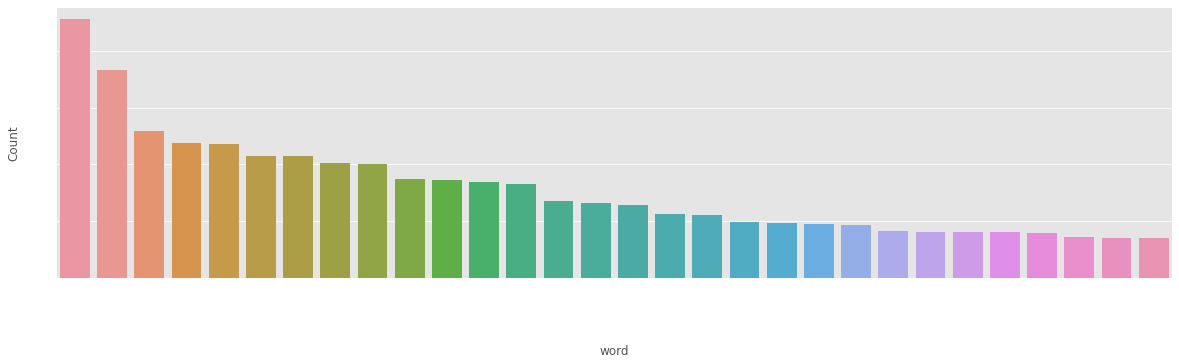

In [134]:
freq_words(list(incidents['Description']))

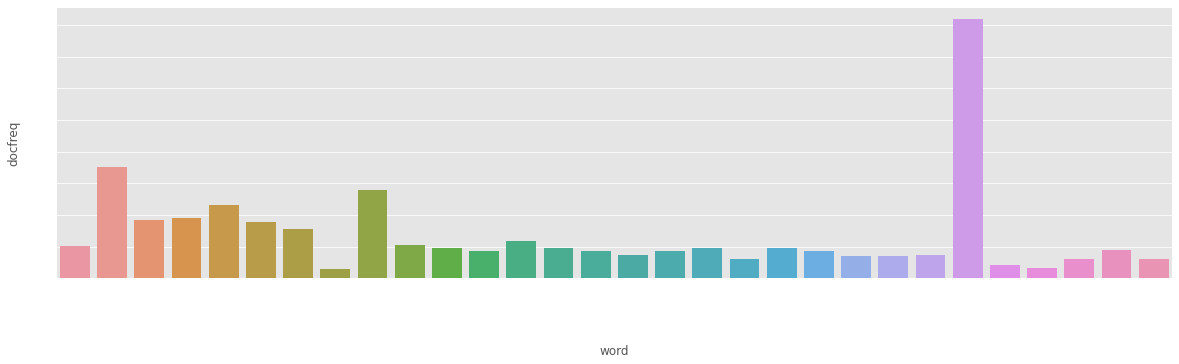

In [142]:
def docfreq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  d = words_df.nlargest(columns="count", n = terms)
  d['docfreq'] = [incidents.Description.str.contains(i).sum() for i in d['word']]
  plt.figure(figsize=(20,5))
  plt.rcParams['xtick.color'] = 'white'
  plt.rcParams['ytick.color'] = 'white'
  ax = sns.barplot(data=d, x= "word", y = "docfreq")
  ax.set(ylabel = 'docfreq')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  plt.show()


docfreq_words(list(incidents['Description']))

None of the words have a document frequency that qualify it to be omitted as a stop word from the dataset, so we will proceed further.

In [143]:
tokenizer = RegexpTokenizer(r'\w+')
incidents['tokens'] = incidents['Description'].apply(tokenizer.tokenize)

In [144]:
incidents['tokens_pos'] = incidents['tokens'].apply(lambda v: pos_tag(v))
incidents.head()

,Description,Caller,Assignment group,desc_lang,tokens,tokens_pos
0,login issue verified user details employee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved,spxjnwir pjlcoqds,grp_0,en,"[login, issue, verified, user, details, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]","[(login, JJ), (issue, NN), (verified, VBD), (user, JJR), (details, NNS), (employee, NN), (manager, NN), (name, NN), (checked, VBD), (user, JJ), (name, NN), (ad, NN), (reset, NN), (password, NN), (advised, VBD), (user, JJ), (login, NN), (check, VB), (caller, NN), (confirmed, VBN), (able, JJ), (login, NN), (issue, NN), (resolved, VBD)]"
1,received gmail com hello team meetings skype meetings etc appearing outlook calendar somebody please advise correct kind,hmjdrvpb komuaywn,grp_0,en,"[received, gmail, com, hello, team, meetings, skype, meetings, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]","[(received, VBN), (gmail, JJ), (com, NN), (hello, NN), (team, NN), (meetings, NNS), (skype, JJ), (meetings, NNS), (etc, VBP), (appearing, VBG), (outlook, NN), (calendar, NN), (somebody, NN), (please, JJ), (advise, RB), (correct, VBP), (kind, NN)]"
2,log vpn received gmail com hi cannot log vpn best,eylqgodm ybqkwiam,grp_0,en,"[log, vpn, received, gmail, com, hi, cannot, log, vpn, best]","[(log, NN), (vpn, NN), (received, VBD), (gmail, JJ), (com, NN), (hi, NN), (cannot, NN), (log, NN), (vpn, NN), (best, JJS)]"
3,unable access hr tool page,xbkucsvz gcpydteq,grp_0,en,"[unable, access, hr, tool, page]","[(unable, JJ), (access, NN), (hr, NN), (tool, NN), (page, NN)]"
4,skype error,owlgqjme qhcozdfx,grp_0,en,"[skype, error]","[(skype, NN), (error, NN)]"


In [146]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 

def get_lemmatized_list(list):
  output = []
  for token, tag in list: 
    wntag = get_wordnet_pos(tag)
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(token) 
    else:
        lemma = lemmatizer.lemmatize(token, pos=wntag) 
    output.append(lemma)
  return output

lemmatizer = WordNetLemmatizer()
incidents['tokens'] = incidents['tokens_pos'].apply(lambda v: get_lemmatized_list(v))


In [148]:
incidents.drop(columns=['Caller','desc_lang','tokens_pos'],inplace=True)
incidents.head()

,Description,Assignment group,tokens
0,login issue verified user details employee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved,grp_0,"[login, issue, verify, user, detail, employee, manager, name, check, user, name, ad, reset, password, advise, user, login, check, caller, confirm, able, login, issue, resolve]"
1,received gmail com hello team meetings skype meetings etc appearing outlook calendar somebody please advise correct kind,grp_0,"[receive, gmail, com, hello, team, meeting, skype, meeting, etc, appear, outlook, calendar, somebody, please, advise, correct, kind]"
2,log vpn received gmail com hi cannot log vpn best,grp_0,"[log, vpn, receive, gmail, com, hi, cannot, log, vpn, best]"
3,unable access hr tool page,grp_0,"[unable, access, hr, tool, page]"
4,skype error,grp_0,"[skype, error]"


In [291]:
def get_bag_of_words(arrOfLists):
  output = ""
  for wordList in arrOfLists:
    for word in wordList:
      output = output+ " " + word
  return output

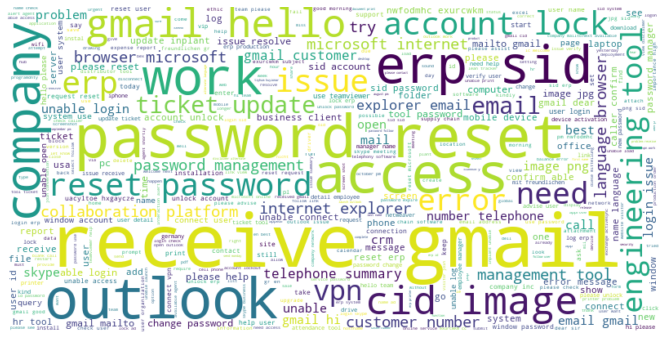

In [293]:
inc_grp0 = incidents[incidents['Assignment group'] =='grp_0']
wordcloud_grp0 = WordCloud(max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(inc_grp0['tokens'].values))
plt.figure( figsize=(12,6) )
plt.imshow(wordcloud_grp0,interpolation='bilinear')
plt.axis("off")
plt.show()

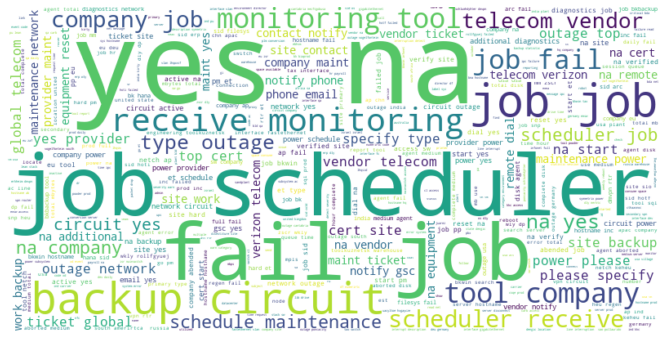

In [295]:
inc_grp8 = incidents[incidents['Assignment group'] =='grp_8']
wordcloud_grp8 = WordCloud(max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(inc_grp8['tokens'].values))
plt.figure( figsize=(12,6) )
plt.imshow(wordcloud_grp8,interpolation='bilinear')
plt.axis("off")
plt.show()

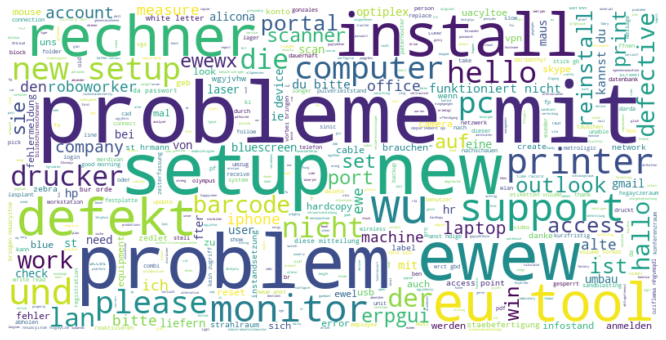

In [296]:
inc_grp24 = incidents[incidents['Assignment group'] =='grp_24']
wordcloud_grp24 = WordCloud(max_words=500, background_color="white",width=800, height=400).generate(get_bag_of_words(inc_grp24['tokens'].values))
plt.figure( figsize=(12,6) )
plt.imshow(wordcloud_grp24,interpolation='bilinear')
plt.axis("off")
plt.show()

In [297]:
def create_bag_of_words(X):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = 'english', ngram_range = (1,3), max_features = 10000) 
    train_data_features = vectorizer.fit_transform(X)
    train_data_features = train_data_features.toarray()
    
    # tfidf transform
    from sklearn.feature_extraction.text import TfidfTransformer
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()

    # Get words in the vocabulary
    vocab = vectorizer.get_feature_names()
      
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [299]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  =  create_bag_of_words(incidents['Description'])

In [300]:
bag_dictionary = pd.DataFrame()
bag_dictionary['ngram'] = vocab
bag_dictionary['count'] = train_data_features[0]
bag_dictionary['tfidf_features'] = tfidf_features[0]

# Sort by raw count
bag_dictionary.sort_values(by=['count'], ascending=False, inplace=True)
# Show top 10
print(bag_dictionary.head(10))

                   ngram  count  tfidf_features
9378                user      3        0.212588
5076               login      3        0.242503
4520               issue      2        0.135418
5107         login issue      2        0.223644
996               caller      1        0.114741
315   advised user login      1        0.136101
314         advised user      1        0.128717
997     caller confirmed      1        0.117308
312              advised      1        0.124820
9547       verified user      1        0.128717


In [301]:
sorted_by_idf = np.argsort(tfidf.idf_)
feature_names = np.array(vectorizer.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['com' 'received' 'tool' 'company' 'gmail com' 'gmail' 'company com'
 'received gmail com' 'received gmail' 'erp']

Features with highest idf:
['filler' 'time ms' 'server company com' 'inq' 'host www companyipg'
 'utislgov' 'utislgov fetaqndw' 'inq industrial' 'time ms ttl'
 'scriptresourcehandler']


#### Pickling the data post language translation for reuse, further preprocessing to be performed

In [149]:
with open('incidents_trans.pickle', 'wb') as output:
    pickle.dump(incidents, output)

In [150]:
with open('incidents_trans.pickle', 'rb') as data:
    incidents = pickle.load(data)

In [151]:
incidents['Group id'] = incidents['Assignment group'].factorize()[0]
incidents.head()

,Description,Assignment group,tokens,Group id
0,login issue verified user details employee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved,grp_0,"[login, issue, verify, user, detail, employee, manager, name, check, user, name, ad, reset, password, advise, user, login, check, caller, confirm, able, login, issue, resolve]",0
1,received gmail com hello team meetings skype meetings etc appearing outlook calendar somebody please advise correct kind,grp_0,"[receive, gmail, com, hello, team, meeting, skype, meeting, etc, appear, outlook, calendar, somebody, please, advise, correct, kind]",0
2,log vpn received gmail com hi cannot log vpn best,grp_0,"[log, vpn, receive, gmail, com, hi, cannot, log, vpn, best]",0
3,unable access hr tool page,grp_0,"[unable, access, hr, tool, page]",0
4,skype error,grp_0,"[skype, error]",0


In [152]:
group_id_df = incidents[['Assignment group', 'Group id']].drop_duplicates().sort_values('Group id')

In [153]:
group_to_id = dict(group_id_df.values)
id_to_group = dict(group_id_df[['Group id', 'Assignment group']].values)

In [ ]:
glove_file = "glove.6B.zip"
#Extract Glove embedding zip file
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [154]:
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

In [155]:
def get_sentence_embedding(tokens, vector):
  if len(tokens)<1:
    return np.zeros(300)
  sentvec = [vector[word] if word in vector else np.zeros(300) for word in tokens]
  length = len(sentvec)
  sum = np.sum(sentvec, axis=0)
  avg = np.divide(sum,length)
  return(avg)

sentence_embeddings = np.array(incidents['tokens'].apply(lambda x: get_sentence_embedding(x, embeddings)).values.tolist())

In [156]:
sentence_embeddings.shape

(8408, 300)

In [157]:
incidents['embedding'] = incidents['tokens'].apply(lambda x: get_sentence_embedding(x, embeddings))

In [158]:
incidents.head()

,Description,Assignment group,tokens,Group id,embedding
0,login issue verified user details employee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved,grp_0,"[login, issue, verify, user, detail, employee, manager, name, check, user, name, ad, reset, password, advise, user, login, check, caller, confirm, able, login, issue, resolve]",0,"[-0.17049456, 0.23485462, 0.021091549, -0.18772002, 0.16588151, -0.091582626, 0.04776728, -0.06810143, 0.07511383, -1.190335, -0.12596925, 0.05009243, 0.18187499, -0.28050336, -0.16544849, 0.033820257, -0.03486396, -0.09580767, -0.09926512, -0.08380863, 0.08889631, 0.1000173, -0.07816067, -0.12579028, -0.23498358, -0.17306645, 0.08838659, 0.23425108, 0.08243521, 0.0802323, 0.10662996, -0.04589958, -0.11348695, 0.027029201, -0.44454026, -0.08713105, -0.18859619, -0.08210505, -0.22327285, -0.05321935, -0.15168923, -0.01842933, 0.016727949, 0.23007657, -0.13486351, -0.0003439697, 0.012851961, -0.055720374, -0.39488062, -0.022903128, 0.24023627, -0.08076567, 0.055422295, -0.099425204, -0.0961892, 0.23189677, 0.020681797, 0.068201125, -0.31125396, -0.04164171, 0.2605802, -0.09413578, -0.057034463, 0.14022106, 0.09553933, -0.047118414, 0.17631976, 0.04466183, 0.27286223, 0.054659706, 0.009265953, 0.0030778323, 0.07628105, 0.15345308, -0.002379544, 0.11171541, 0.07082161, -0.007109039, 0.05813767, -0.29456666, -0.058092456, 0.1813776, 4.703924e-05, -0.08335093, 0.14770097, 0.09848583, -0.40965, -0.056702163, -0.022844866, 0.048319027, -0.67520124, 0.17087336, -0.11170966, -0.060674746, 0.18903255, 0.10813737, -0.26286697, -0.04307722, 0.31633958, -0.5484702, ...]"
1,received gmail com hello team meetings skype meetings etc appearing outlook calendar somebody please advise correct kind,grp_0,"[receive, gmail, com, hello, team, meeting, skype, meeting, etc, appear, outlook, calendar, somebody, please, advise, correct, kind]",0,"[-0.17810726, -0.056894936, -0.12956166, -0.12007887, -0.0009445285, -0.014663214, -0.1493577, -0.0015352917, -0.029082727, -0.94193614, 0.089044355, 0.06200918, 0.10757319, -0.03911353, 0.030544769, -0.07361088, -0.0621002, 0.04305782, -0.033532, -0.13736682, 0.08582912, 0.08332735, 0.027482072, 0.07820247, -0.19174664, -0.11568336, 0.13991676, 0.01659535, 0.1547937, -0.060211133, 0.06960905, 0.045653146, 0.0024249274, 0.059539452, -0.667053, 0.12857324, -0.11287147, -0.017877236, -0.07817159, -0.06258583, -0.07454861, 0.008712001, -0.20327261, 0.18648955, -0.09297468, -0.068027735, 0.05862771, -0.05796721, -0.21714558, -0.08417052, 0.1959024, -0.062419526, 0.003233236, -0.038790967, -0.14389199, 0.17713399, 0.10834821, 0.10918584, -0.012344237, -0.10830538, 0.12697089, -0.09449664, -0.09325277, 0.06242559, -0.081199415, -0.090885766, 0.19363767, -0.055484295, -0.08777057, 0.006760057, 0.014801713, 0.049610306, -0.07244011, 0.11133585, 0.053282183, -0.06632447, 0.18225408, 0.028431166, -0.06926665, -0.118603006, -0.07740948, 0.13107076, 0.0053932862, 0.0075611193, 0.17002848, 0.0808603, -0.15517366, 0.15762746, 0.10964939, 0.023168907, -0.2879096, 0.03783853, -0.18420015, -0.20137306, 0.14210542, 0.09114417, -0.28101823, -0.061468348, 0.022547359, -0.33842713, ...]"
2,log vpn received gmail com hi cannot log vpn best,grp_0,"[log, vpn, receive, gmail, com, hi, cannot, log, vpn, best]",0,"[-0.2745632, 0.072436005, -0.16555531, -0.07464121, 0.1538573, -0.033598997, 0.038686004, -0.13302079, -0.17959101, -0.6184244, 0.031062003, 0.114938594, -0.039680503, -0.22667798, 0.022106495, 0.018786399, -0.16461961, 0.07117601, 0.048901796, 0.03202742, 0.2676262, -0.1718109, 0.1811919, 0.048105896, -0.17674059, -0.0868487, 0.1277575, 0.09800321, 0.20910588, 0.15408464, -0.19920799, 0.3134361, -0.121514, -0.1569686, -0.18881801, 0.090237, -0.023096845, -0.11750201, -0.010889072, -0.198184, -0.14606938, 0.030854205, -0.14836718, 0.3269492, -0.06810621, -0.18042609, 0.14055249, 0.12061985, -0.0312477, -0.10984869, 0.25538158, 0.03

In [242]:
inc_clus = pd.DataFrame(incidents['Assignment group'].unique(),columns=['Assignment group'])

In [243]:
for i in incidents['Assignment group'].unique():
  inc_clus.loc[inc_clus['Assignment group']==i,'embedding'] = pd.Series([np.mean(incidents[incidents['Assignment group']==i]['embedding'])],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  inc_clus.loc[inc_clus['Assignment group']==i,'frequency'] = pd.Series(incidents[incidents['Assignment group']==i].shape[0],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')

In [245]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

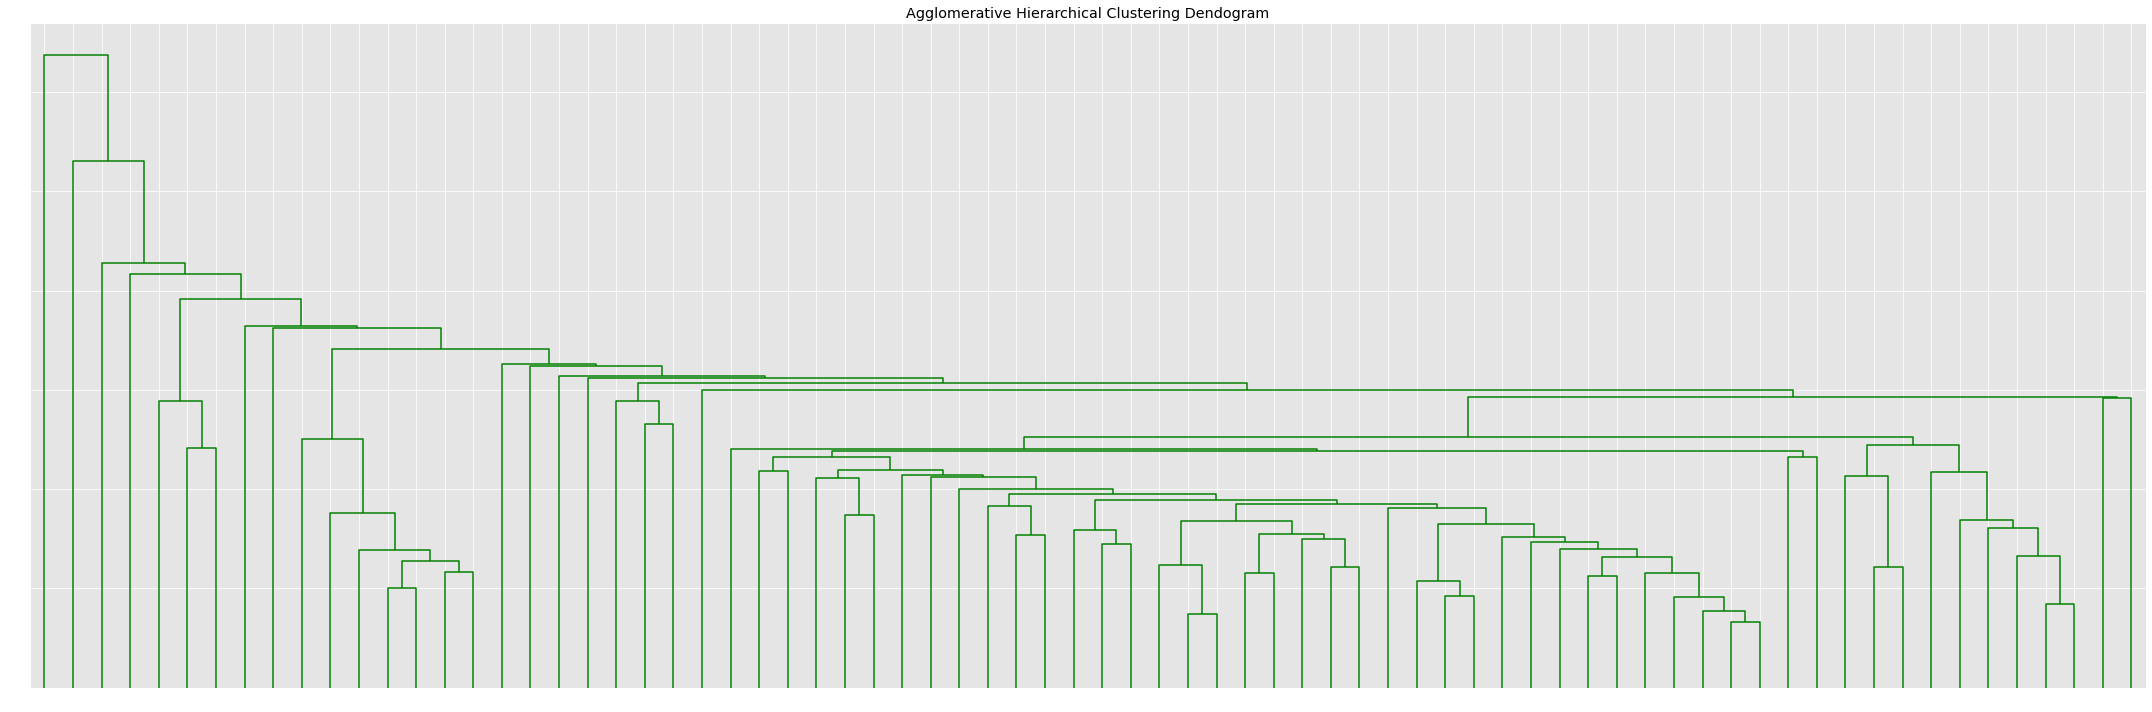

In [246]:
plt.figure(figsize=(30, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
Z = linkage(inc_clus['embedding'].values.tolist(), metric='euclidean', method='average')
dendrogram(Z, leaf_rotation=90, color_threshold=40, leaf_font_size=8)
plt.tight_layout()

From the above graph, records for specific groups are largely different from most other groups which seem to be similar. Let us choose 12 clusters for a start.

In [247]:
model = AgglomerativeClustering(n_clusters=45, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=45)

In [248]:
inc_clus['class'] = model.labels_
inc_clus['class'].value_counts()

0     13
8      5
2      5
1      4
3      3
4      3
18     2
10     2
7      1
6      1
9      1
21     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
5      1
19     1
20     1
44     1
43     1
23     1
42     1
41     1
40     1
39     1
38     1
37     1
36     1
35     1
34     1
33     1
32     1
31     1
30     1
29     1
28     1
27     1
26     1
25     1
24     1
22     1
Name: class, dtype: int64

In [251]:
for i in incidents['Assignment group'].unique():
  incidents.loc[incidents['Assignment group']==i,'class'] = inc_clus[inc_clus['Assignment group']==i]['class'].values[0]

In [255]:
clus_arrngmt = pd.DataFrame([(i,inc_clus[inc_clus['class']==i]['Assignment group'].values) for i in inc_clus['class'].unique()],columns=['cluster id','cluster groups'])
clus_arrngmt.set_index('cluster id',inplace=True)
clus_arrngmt['ticket_counts'] = incidents['class'].value_counts()
clus_arrngmt['class_counts'] = inc_clus['class'].value_counts()
clus_arrngmt.reset_index(inplace=True)
clus_arrngmt.head()

,cluster id,cluster groups,ticket_counts,class_counts
0,8,"[grp_0, grp_12, grp_14, grp_2, grp_34]",4603,5
1,10,"[grp_1, grp_47]",58,2
2,4,"[grp_3, grp_19, grp_28]",459,3
3,18,"[grp_4, grp_37]",116,2
4,2,"[grp_5, grp_6, grp_8, grp_9, grp_60]",1224,5


In [264]:
clus_arrngmt.sort_values(by='ticket_counts',ascending=False,inplace=True)
clus_arrngmt=clus_arrngmt[clus_arrngmt['ticket_counts']>100]
clus_arrngmt.sum()

cluster id         77
ticket_counts    7880
class_counts       36
dtype: int64

In [333]:
clus_arrngmt

,cluster id,cluster groups,ticket_counts,class_counts
0,8,"[grp_0, grp_12, grp_14, grp_2, grp_34]",4603,5
4,2,"[grp_5, grp_6, grp_8, grp_9, grp_60]",1224,5
7,0,"[grp_11, grp_13, grp_15, grp_18, grp_20, grp_21, grp_22, grp_25, grp_29, grp_40, grp_41, grp_44, grp_45]",744,13
2,4,"[grp_3, grp_19, grp_28]",459,3
11,1,"[grp_24, grp_33, grp_42, grp_49]",435,4
8,3,"[grp_16, grp_26, grp_27]",159,3
6,41,[grp_10],140,1
3,18,"[grp_4, grp_37]",116,2


In [268]:
clus_arrngmt['cluster id'].values

array([ 8,  2,  0,  4,  1,  3, 41, 18])

We will only focus on the 36 groups above clustered into 8 classes for proceeding further. Other clusters/classes have very less number of records for our model to understand and predict.

In [272]:
incidents_clust = incidents[incidents['class'].isin(clus_arrngmt['cluster id'].values)]
incidents_clust.shape

(7880, 6)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(incidents_clust['embedding'].values.tolist(), incidents_clust['class'], test_size=0.15, random_state=10)

In [275]:
lgr = LogisticRegression(random_state=8)
lgr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [276]:
print(accuracy_score(y_test,lgr.predict(X_test)))

0.7927241962774958


In [277]:
print(classification_report(y_test,lgr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59       109
         1.0       0.73      0.66      0.69        62
         2.0       0.89      0.89      0.89       174
         3.0       0.00      0.00      0.00        21
         4.0       0.50      0.29      0.37        76
         8.0       0.82      0.92      0.87       715
        18.0       0.50      0.08      0.13        13
        41.0       0.30      0.25      0.27        12

    accuracy                           0.79      1182
   macro avg       0.55      0.45      0.48      1182
weighted avg       0.76      0.79      0.77      1182



Let us try with bag of words

In [311]:
#X = incidents_clust['Description']
y = incidents_clust['class']
X_train, X_test, y_train, y_test = train_test_split(tfidf_features,y, test_size = 0.25)

In [310]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  =  create_bag_of_words(incidents_clust['Description'])

### Logistic Regression

In [312]:
ml_model = LogisticRegression(C = 100,random_state = 10)
ml_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [316]:
correctly_identified_y = ml_model.predict(X_train) == y_train
accuracy = np.mean(correctly_identified_y) * 100
print ('Train Accuracy = %.0f%%' %accuracy)

Train Accuracy = 99%


In [315]:
correctly_identified_y = ml_model.predict(X_test) == y_test
accuracy = np.mean(correctly_identified_y) * 100
print ('Test Accuracy = %.0f%%' %accuracy)

Test Accuracy = 82%


In [317]:
print(classification_report(y_test,ml_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70       190
         1.0       0.85      0.72      0.78       116
         2.0       0.91      0.86      0.88       305
         3.0       0.54      0.17      0.25        42
         4.0       0.54      0.40      0.46       112
         8.0       0.85      0.93      0.89      1141
        18.0       0.53      0.34      0.42        29
        41.0       0.80      0.34      0.48        35

    accuracy                           0.82      1970
   macro avg       0.71      0.56      0.61      1970
weighted avg       0.81      0.82      0.81      1970



### Random Forest

In [325]:
le = LabelEncoder()
tokenizer = Tokenizer(num_words= 10000)
tokenizer.fit_on_texts(incidents_clust['Description'])
maxlen = 300

In [326]:
X_M1 = tokenizer.texts_to_sequences(incidents_clust['Description'])
X_M1 = pad_sequences(X_M1, maxlen = maxlen)
y_M1 = np.asarray(incidents_clust['class'])


In [327]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_M1,y_M1, test_size = 0.3)

In [328]:
clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight="balanced")
clf.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [329]:
correctly_identified_y = clf.predict(X_train_2) == y_train_2
accuracy = np.mean(correctly_identified_y) * 100
print ('Train Accuracy = %.0f%%' %accuracy)

Train Accuracy = 98%


In [330]:
correctly_identified_y = clf.predict(X_test_2) == y_test_2
accuracy = np.mean(correctly_identified_y) * 100
print ('Test Accuracy = %.0f%%' %accuracy)

Test Accuracy = 71%


In [331]:
print(classification_report(y_test_2, clf.predict(X_test_2)))

              precision    recall  f1-score   support

         0.0       0.25      0.20      0.22       228
         1.0       0.61      0.45      0.52       140
         2.0       0.92      0.81      0.86       345
         3.0       0.00      0.00      0.00        50
         4.0       0.31      0.08      0.13       133
         8.0       0.73      0.90      0.81      1388
        18.0       1.00      0.10      0.18        30
        41.0       0.94      0.30      0.45        50

    accuracy                           0.71      2364
   macro avg       0.59      0.36      0.40      2364
weighted avg       0.67      0.71      0.67      2364



### K nearest Neighbor

In [334]:
NNH = KNeighborsClassifier(n_neighbors=8, weights = 'distance')

In [335]:
NNH.fit(X_train_2, y_train_2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')

In [336]:
print("Training score", NNH.score(X_train_2, y_train_2))
print("Test score",  NNH.score(X_test_2, y_test_2))

Training score 0.9931109499637418
Test score 0.6806260575296108


In [337]:
expected = y_test_2
predicted = NNH.predict(X_test_2)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

         0.0       0.20      0.07      0.10       228
         1.0       0.52      0.31      0.39       140
         2.0       0.81      0.79      0.80       345
         3.0       0.00      0.00      0.00        50
         4.0       0.06      0.02      0.02       133
         8.0       0.70      0.91      0.79      1388
        18.0       0.40      0.07      0.11        30
        41.0       0.89      0.32      0.47        50

    accuracy                           0.68      2364
   macro avg       0.45      0.31      0.34      2364
weighted avg       0.60      0.68      0.62      2364

[[  15    4    9    0    4  196    0    0]
 [   4   44    2    1    2   87    0    0]
 [   6    0  271    0    0   67    0    1]
 [   6    0    1    0    0   43    0    0]
 [   5    3    5    0    2  117    1    0]
 [  38   33   34    1   20 1259    2    1]
 [   1    1    3    0    3   20    2    0]
 [   1    0   11    0    0   22    0   16]]


### Model with LSTM

In [338]:
#  Capping the maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 15000 #15000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250 #150
# This is fixed.
EMBEDDING_DIM = 100 # TODO REduce to 50 ~ 75
N_CLASSES = 8
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True,char_level = False) 
tokenizer.fit_on_texts(incidents_clust['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11951 unique tokens.


In [339]:
X_nl = tokenizer.texts_to_sequences(incidents_clust['Description'].values)
X_nl = pad_sequences(X_nl, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_nl.shape)

Shape of data tensor: (7880, 250)


In [340]:
y_nl = pd.get_dummies(incidents_clust['class']).values
print('Shape of label tensor:', y_nl.shape)

Shape of label tensor: (7880, 8)


In [341]:
X_nl_train, X_nl_test, y_nl_train, y_nl_test = train_test_split(X_nl,y_nl, test_size = 0.25, random_state = 10)

In [342]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, 
                            input_length= MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences) 
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 100)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 1,618,280
Trainable params: 1,618,280
Non-trainable params: 0
_________________________________________________________________


In [345]:
model.fit(X_nl_train, y_nl_train, epochs=20, batch_size=100,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
45/45 [==============================] - 51s 1s/step - loss: 1.3945 - acc: 0.6060 - val_loss: 1.0092 - val_acc: 0.7145
Epoch 2/20
45/45 [==============================] - 51s 1s/step - loss: 0.9101 - acc: 0.7175 - val_loss: 0.8315 - val_acc: 0.7510
Epoch 3/20
45/45 [==============================] - 51s 1s/step - loss: 0.6842 - acc: 0.7875 - val_loss: 0.7477 - val_acc: 0.7760
Epoch 4/20
45/45 [==============================] - 51s 1s/step - loss: 0.5206 - acc: 0.8394 - val_loss: 0.7415 - val_acc: 0.7794
Epoch 5/20
45/45 [==============================] - 51s 1s/step - loss: 0.4049 - acc: 0.8818 - val_loss: 0.7620 - val_acc: 0.7936
Epoch 6/20
45/45 [==============================] - 51s 1s/step - loss: 0.3155 - acc: 0.9088 - val_loss: 0.8202 - val_acc: 0.7700
Epoch 7/20
45/45 [==============================] - 51s 1s/step - loss: 0.2545 - acc: 0.9328 - val_loss: 0.8474 - val_acc: 0.7727


In [346]:
scores_training, accuracy_training = model.evaluate(X_nl_train, y_nl_train, batch_size=100)
print('Training Accuracy :',accuracy_training*100)
scores_testing, accuracy_testing = model.evaluate(X_nl_test, y_nl_test, batch_size=100) 
print("Testing Accuracy: ",(accuracy_testing*100))


60/60 [==============================] - 10s 169ms/step - loss: 0.3609 - acc: 0.9049
Training Accuracy : 90.49069285392761
20/20 [==============================] - 3s 162ms/step - loss: 0.7980 - acc: 0.7863
Testing Accuracy:  78.62944006919861
